In [262]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import minimize
import sympy as sym
from sympy.vector import CoordSys3D
from sympy.utilities.lambdify import lambdastr, implemented_function, lambdify
from glob import glob

from sys import path
path.insert(0, "lib")
from colorline import colorline
from SGD_utils import *

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
from fipy import Variable, FaceVariable, CellVariable, Grid1D, ExplicitDiffusionTerm, TransientTerm, DiffusionTerm, Viewer, ExponentialConvectionTerm

from fipy.tools import numerix

## Fokker-Planck utility functions

In [3]:
def get_coeffs(q, print_func=False):
    w, w0, v, ve, l, b = sym.symbols('w w0 v ve l b')
    N = CoordSys3D('N')
    grad_q = sym.diff(q, w)
    h = -l*v*q*grad_q
    g = (l/sym.sqrt(b))*(-v*q*grad_q*N.i + sym.sqrt(v*ve/2)*grad_q*N.j)
    d1 = h + g.dot(sym.diff(g, w))
    d2 = g.dot(g)
    convection = -d1 + sym.diff(d2, w)
    if print_func:
        display("convection term:", sym.factor(convection))
        display("diffusion term:", d2)
    return lambdify((l, v, ve, w0, b, w), convection), lambdify((l, v, ve, w0, b, w), d2)

In [4]:
def get_FP_data(q, nw, lr, v, ve, w0, b, L, dt, steps):
    convection, d2 = get_coeffs(q)
    
    mesh = Grid1D(nx=nw, Lx=L)
    
    P = CellVariable(mesh=mesh, name=r"$P$")
    P.value = 0.
    w = mesh.cellCenters[0]
    P.setValue(1/L)


    w = mesh.cellCenters[0]
    D2 = d2(lr, v, ve, w0, b, w)
    
    w = mesh.faceCenters[0]
    minusD1plusgradD2 = convection(lr, v, ve, w0, b, w)
    # unit vector
    u = FaceVariable(mesh=mesh, value = 1., rank=1)
    
    # explicit
    eq = TransientTerm() == DiffusionTerm(CellVariable(mesh=mesh, value = D2)) + ExponentialConvectionTerm(u * FaceVariable(mesh=mesh, value = minusD1plusgradD2))

    Ps = [P.copy()]
    for step in range(steps):
        eq.solve(var=P, dt=dt)
        Ps.append(P.copy())

    return mesh.x, Ps

## SGD utility functions

In [255]:
def get_SGD_data_lin(std_epsilon, lr, b, nsamp, nsteps, seed):
    """
    For SGD data with linear potential, 
    autocorrelation time is short enough that simulating one SGD trajectory is sufficient to approximate the trajectory distribution
    """
    
    def q(w):
        return w-.5
    
    def grad_q(w):
        return 1.

    state = np.random.RandomState(seed=seed)
    winit = state.uniform(0., 1.)
    S = SGD(std_epsilon, lr, q, grad_q, winit, nsamp, b, seed)
    S.evolve(nsteps)
    return np.array(S.w)

In [81]:
def get_approxSGD_data_lin(std_epsilon, lr, b, nsteps, seed):
    """
    For SGD data with linear potential, 
    autocorrelation time is short enough that simulating one SGD trajectory is sufficient to approximate the trajectory distribution
    """
    
    def q(w):
        return w-.5
    
    def grad_q(w):
        return 1.

    state = np.random.RandomState(seed=seed)
    winit = state.uniform(0., 1.)
    S = ApproxSGD(std_epsilon, lr, q, grad_q, winit, b, seed)
    S.evolve(nsteps)
    return np.array(S.w)

In [236]:
def get_tailsSGD_data_lin(std_epsilon, lr, b, nsteps, seed, threshold):
    """
    For SGD data with linear potential, 
    autocorrelation time is short enough that simulating one SGD trajectory is sufficient to approximate the trajectory distribution
    """
    
    def q(w):
        return w-.5
    
    def grad_q(w):
        return 1.

    state = np.random.RandomState(seed=seed)
    winit = state.uniform(0., 1.)
    S = TailsSGD(std_epsilon, lr, q, grad_q, winit, b, seed, threshold)
    S.evolve(nsteps)
    return np.array(S.w)

In [88]:
def get_approxSGD_data_nonlin_regular(std_epsilon, lr, b, nsteps, seed):
    """
    SGD data with non-linear but regular potential
    """
    
    def q(w):
        return (w-.5)*(w*w+1)
    
    def grad_q(w):
        return w*w+1 + 2*w*(w-.5)

    state = np.random.RandomState(seed=seed)
    winit = state.uniform(0., 1.)
    S = ApproxSGD(std_epsilon, lr, q, grad_q, winit, b, seed)
    S.evolve(nsteps)
    return np.array(S.w)

In [128]:
def get_approxSGD_data_singular(std_epsilon, lr, b, nsteps, seed, a):
    """
    SGD data with singular double-well potential
    """
    
    def q(w):
        return (w+a)*(w-a)**2.
    
    def grad_q(w):
        return (w-a)**2. + 2.*(w+a)*(w-a)

    state = np.random.RandomState(seed=seed)
    winit = state.uniform(-a-.2, a+.2)
    S = ApproxSGD(std_epsilon, lr, q, grad_q, winit, b, seed)
    S.evolve(nsteps)
    return np.array(S.w)

In [269]:
def get_TailsSGD_data_singular(std_epsilon, lr, b, nsteps, seed, a, threshold):
    """
    SGD data with singular double-well potential
    """
    
    def q(w):
        return (w+a)*(w-a)**2.
    
    def grad_q(w):
        return (w-a)**2. + 2.*(w+a)*(w-a)

    state = np.random.RandomState(seed=seed)
    winit = state.uniform(-a-.2, a+.2)
    S = TailsSGD(std_epsilon, lr, q, grad_q, winit, b, seed, threshold)
    S.evolve(nsteps)
    return np.array(S.w)

In [156]:
def get_SGD_data_singular(std_epsilon, lr, b, nsamp, nsteps, seed, a):
    """
    SGD data with singular double-well potential
    """
    
    def q(w):
        return (w+a)*(w-a)**2.
    
    def grad_q(w):
        return (w-a)**2. + 2.*(w+a)*(w-a)

    state = np.random.RandomState(seed=seed)
    winit = state.uniform(-a-.2, a+.2)
    S = SGD(std_epsilon, lr, q, grad_q, winit, nsamp, b, seed)
    S.evolve(nsteps)
    return np.array(S.w)

## Linear model, steady state

### Tests with different autocorrelation times

In [235]:
stde = 1.
lr = 0.01
b = 10
nsteps = 10**6
ws = [get_approxSGD_data_lin(stde, lr, b, nsteps, seed) for seed in range(10)]
ws = np.array(ws)

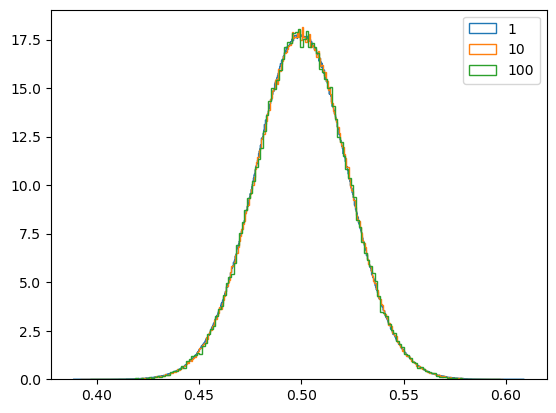

In [237]:
# histograms for different autocorrelation times
ti = 10**3
for tc in [1, 10, 100]:
    data = ws.T[ti::tc].ravel()
    plt.hist(data, bins='auto', histtype='step', label=f'{tc}', density=True)
plt.legend()
plt.show()

### GLD / SGD / FP comparison

In [461]:
"""
FP
"""

lr = 0.01
stde = 1
b = 20

w, w0 = sym.symbols('w w0')
q = (w-w0)
nw = 300
v = 1.
ve = stde**2.
w0 = 0.5
L = 1
dt = 1.
steps = int(10**3/dt)
x, Ps = get_FP_data(q, nw, lr, v, ve, w0, b, L, dt, steps)

In [462]:
"""
GLD
"""

nsteps = 10**6
wsGLD = [get_approxSGD_data_lin(stde, lr, b, nsteps, seed) for seed in range(10)]
wsGLD = np.array(wsGLD)

In [463]:
"""
GLD with Student tails
"""

# proportion of Student samples in the distribution
t = .4

nsteps = 10**5
wsTails = [get_tailsSGD_data_lin(stde, lr, b, nsteps, seed, t) for seed in range(10)]
wsTails = np.array(wsTails)

In [464]:
"""
SGD
"""

nsteps = 2*10**3
nsamp = 10**4
wsSGD = [get_SGD_data_lin(stde, lr, b, nsamp, nsteps, seed) for seed in range(200)]
wsSGD = np.array(wsSGD)

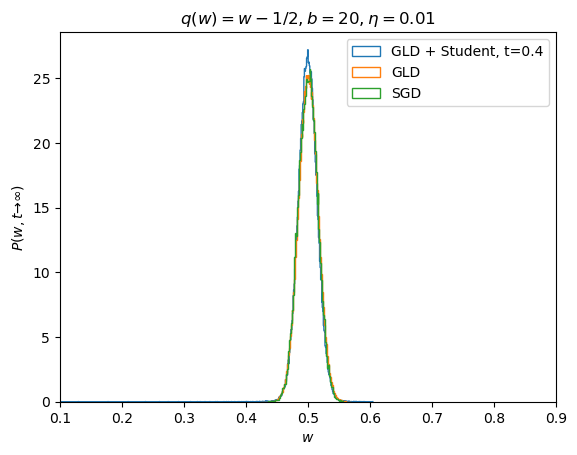

In [479]:
# histograms for different autocorrelation times
ti = 700
tc = 10
fig, ax = plt.subplots()

data = wsTails.T[ti::tc].ravel()
# data = data[~np.argwhere(np.isnan(data))]
plt.hist(data, bins='auto', histtype='step', label=f'GLD + Student, t={t}', density=True)

data = wsGLD.T[ti::tc].ravel()
plt.hist(data, bins='auto', histtype='step', label=f'GLD', density=True)

data = wsSGD.T[ti::tc].ravel()
plt.hist(data, bins='auto', histtype='step', label=f'SGD', density=True)

# plt.plot(x, Ps[-1], label='FP')

# ax.set_yscale('log')
# plt.ylim(bottom=1e-3, top=50)
plt.xlim(0.1, 0.9)
plt.legend()
plt.title(f'$q(w)=w-1/2,b={b},\\eta={lr}$')
plt.xlabel('$w$')
plt.ylabel('$P(w,t\\to \infty)$')
plt.savefig('distrib.png')
plt.show()

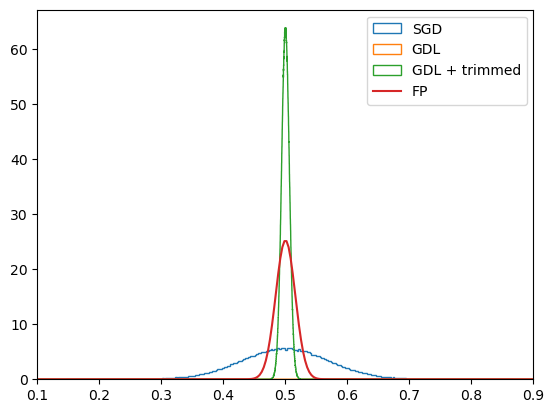

In [299]:
# histograms for different autocorrelation times
ti = 10
tc = 1
fig, ax = plt.subplots()

data = wsSGD.T[ti::tc].ravel()
plt.hist(data, bins='auto', histtype='step', label=f'SGD', density=True)

data = ws.T[ti::tc].ravel()
plt.hist(data, bins='auto', histtype='step', label=f'GDL', density=True)

data = wsTails.T[ti::tc].ravel()
plt.hist(data, bins='auto', histtype='step', label=f'GDL + trimmed', density=True)

plt.plot(x, Ps[-1], label='FP')

# ax.set_yscale('log')
# plt.ylim(bottom=1e-3, top=50)
plt.xlim(0.1, 0.9)
plt.legend()
plt.show()

## Regular, non-linear model, finite time

In [89]:
sgd_datas = []
stdes = [1.2]
for stde in stdes:
    files = glob(f'data/nonlin_stde{stde:g}*.dat')
    sgd_data = np.array([np.loadtxt(file) for file in files])
    sgd_datas.append(sgd_data)

In [99]:
"""
Approx SGD
"""
stde = 1.2
lr = 0.01
b = 20
nsteps = 10
ws = np.array([get_approxSGD_data_nonlin_regular(stde, lr, b, nsteps, seed) for seed in range(5*10**4)])

In [92]:
w, w0 = sym.symbols('w w0')
q = (w-w0)*(w**2+1)

nw = 500
lr = 0.01
stde = 1.2
v = 1.
ve = stde**2.
w0 = 0.5
b = 20
L = 1
dt = .05
steps = int(10/dt)

fp_datas = []
for stde in stdes:
    ve = stde**2.
    x, Ps = get_FP_data(q, nw, lr, v, ve, w0, b, L, dt, steps)
    fp_datas.append(Ps)

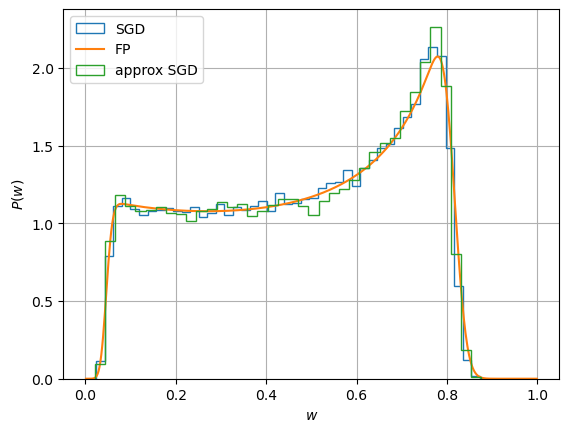

In [100]:
for sgd_data, Ps, stde in zip(sgd_datas, fp_datas, stdes):
    plt.hist(sgd_data.T[-1], histtype='step', density=True, bins='auto', label='SGD')
    plt.plot(x, Ps[-1], label='FP')
plt.hist(ws.T[-1], histtype='step', density=True, bins='auto', label='approx SGD')

plt.xlabel(r"$w$")
plt.ylabel(r"$P(w)$")
plt.grid()
plt.legend()
plt.savefig("dynamics_1d_singular_model.png", bbox_inches="tight", dpi=150)
plt.show()

## Singular, double-well potential, escape rate

### GLD

In [226]:
a = 2.01
stde = 1.
lr = .01
b = 100
nsteps = 100
nseeds = 10**3
ws_gld = []
for i in range(0, 5*nseeds, nseeds):
    print(i)
    ws_gld.append(np.array([get_approxSGD_data_singular(stde, lr, b, nsteps, seed, a) for seed in range(i,i+nseeds)]))

0
1000
2000
3000
4000


In [227]:
freq = []
for ws in ws_gld:
    inan = np.argwhere(np.isnan(ws))
    filt = np.array([ww for ww in ws if not(np.isnan(ww).any())])
    freq.append( np.mean(filt < -a/3., axis = 0) )

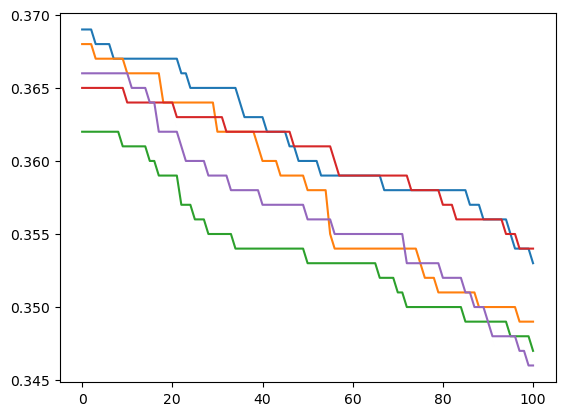

In [228]:
fig, ax = plt.subplots()
for f in freq:
    plt.plot(f)
# plt.plot(freq)
# plt.plot(freq_fp)
plt.show()

### GLD with Student tails

In [417]:
a = 2
stde = 1.
lr = .01
b = 10
nsteps = 200
nseeds = 4*10**4
ws_gld = []
ts = [0., .4, .5]
for t in ts:
    print(t)
    ws_gld.append(np.array([get_TailsSGD_data_singular(stde, lr, b, nsteps, seed, a, t) for seed in range(nseeds)]))

0.0


/var/folders/lb/0wvyvp693x9fpgwng1wv1hwc0000gn/T/ipykernel_38885/4242575401.py:7: RuntimeWarning: overflow encountered in scalar multiply
  return (w+a)*(w-a)**2.
/var/folders/lb/0wvyvp693x9fpgwng1wv1hwc0000gn/T/ipykernel_38885/4242575401.py:7: RuntimeWarning: overflow encountered in scalar power
  return (w+a)*(w-a)**2.
/var/folders/lb/0wvyvp693x9fpgwng1wv1hwc0000gn/T/ipykernel_38885/4242575401.py:10: RuntimeWarning: overflow encountered in scalar power
  return (w-a)**2. + 2.*(w+a)*(w-a)
/var/folders/lb/0wvyvp693x9fpgwng1wv1hwc0000gn/T/ipykernel_38885/4242575401.py:10: RuntimeWarning: overflow encountered in scalar multiply
  return (w-a)**2. + 2.*(w+a)*(w-a)


0.4


/var/folders/lb/0wvyvp693x9fpgwng1wv1hwc0000gn/T/ipykernel_38885/4242575401.py:10: RuntimeWarning: overflow encountered in scalar add
  return (w-a)**2. + 2.*(w+a)*(w-a)


0.5


In [460]:
for t, ws in zip(ts, ws_gld):
    filename = f'processed_data/traj_a{a}_stde{stde}_lr{lr}_b{b}_t{t}.dat'
    np.savetxt(filename, ws)

In [418]:
freq = []
for ws in ws_gld:
    inan = np.argwhere(np.isnan(ws))
    filt = np.array([ww for ww in ws if not(np.isnan(ww).any())])
    freq.append( np.mean(filt < -a/3., axis = 0) )

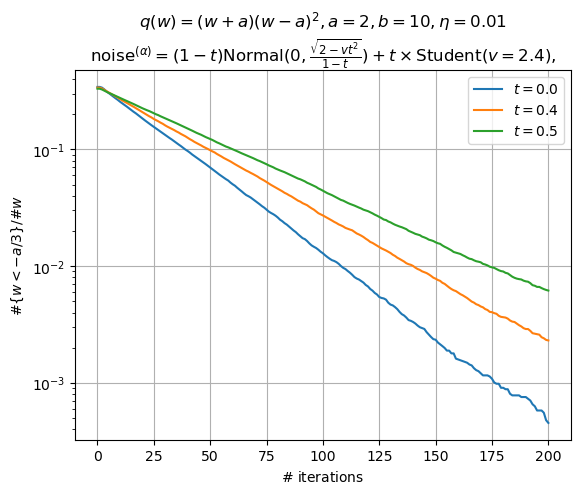

In [458]:
fig, ax = plt.subplots()
for f, t in zip(freq, ts):
    plt.plot(f, label=f'$t={t}$')
ax.set_yscale('log')
plt.legend()
plt.grid()
plt.xlabel(r'$\#$ iterations')
plt.ylabel(r'$\#\{w<-a/3\}/\#{}w$')
title = f'$q(w)=(w+a)(w-a)^2, a={a:g}, b={b}, \\eta={lr:g}$\n'
title += r'$\mathrm{noise}^{(\alpha)}=(1-t)\mathrm{Normal}(0, \frac{\sqrt{2-v t^2}}{1-t})+t \times \mathrm{Student}(v=2.4), $'
plt.title(title)
plt.savefig('Student_GLD.png')
plt.show()

### Exact SGD

In [231]:
a = 2.01
stde = 1.
lr = .01
b = 100
nsteps = 100
nsamp = 10**5
ws_sgd = []
for nsamp in [300, 10**3, 10**4]:
    ws_sgd.append(np.array([get_SGD_data_singular(stde, lr, b, nsamp, nsteps, seed, a) for seed in range(1000)]))

In [233]:
freq_sgd = []
for ws in ws_sgd:
    inan = np.argwhere(np.isnan(ws))
    filt = np.array([ww for ww in ws if not(np.isnan(ww).any())])
    freq_sgd.append( np.mean(filt < -a/3., axis = 0) )

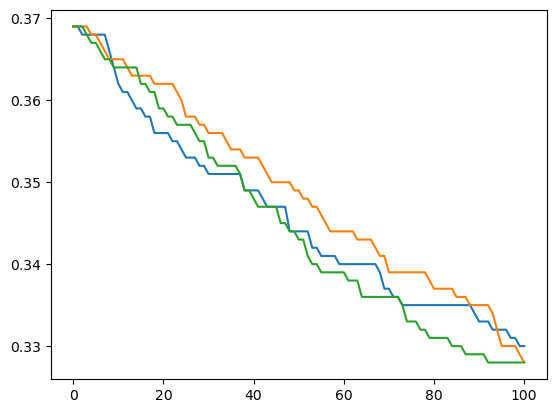

In [234]:
fig, ax = plt.subplots()
for f in freq_sgd:
    plt.plot(f)
# plt.plot(freq)
# plt.plot(freq_fp)
plt.show()

In [200]:
"""
FP
"""
w, w0 = sym.symbols('w w0')
q = (w-2)*(w-2*w0-2)**2

nw = 500
v = 1.
ve = stde**2.
w0 = a
L = 2*w0+4
dt = .05
steps = int(100/dt)

fp_datas = []
x, Ps = get_FP_data(q, nw, lr, v, ve, w0, b, L, dt, steps)
fp_datas.append(Ps)

In [218]:
norm = sum(Ps[0])
min_reg = 2
min_sing = 2*w0 + 2
barrier = (2*min_reg + min_sing)/3
ilim = int(nw*barrier/L)
freq_fp = np.sum(np.array(Ps).T[:ilim], axis=0)

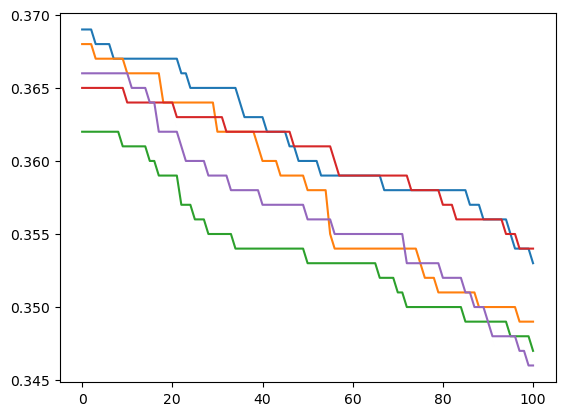

In [228]:
fig, ax = plt.subplots()
for f in freq:
    plt.plot(f)
# plt.plot(freq)
# plt.plot(freq_fp)
plt.show()

In [ ]:
v=a*(−1+2)/(−1+aσ^2)